#### Imports and Dataset Loading

In [180]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mutual_info_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_text
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold

import xgboost as xgb

from IPython.display import display

from tqdm.auto import tqdm

sns.set_style('darkgrid')
plt.rcParams['font.size'] = 14
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.facecolor'] = '#00000000'
%matplotlib inline

### Attribute Information
```
* gender: Gender of self
* age: Age of self
* age_o: Age of partner
* d_age: Difference in age
* race: Race of self
* race_o: Race of partner
* samerace: Whether the two persons have the same race or not.
* importance_same_race: How important is it that partner is of same race?
* importance_same_religion: How important is it that partner has same religion?
* field: Field of study
* pref_o_attractive: How important does partner rate attractiveness
* pref_o_sinsere: How important does partner rate sincerity
* pref_o_intelligence: How important does partner rate intelligence
* pref_o_funny: How important does partner rate being funny
* pref_o_ambitious: How important does partner rate ambition
* pref_o_shared_interests: How important does partner rate having shared interests
* attractive_o: Rating by partner (about me) at night of event on attractiveness
* sincere_o: Rating by partner (about me) at night of event on sincerity
* intelligence_o: Rating by partner (about me) at night of event on intelligence
* funny_o: Rating by partner (about me) at night of event on being funny
* ambitous_o: Rating by partner (about me) at night of event on being ambitious
* shared_interests_o: Rating by partner (about me) at night of event on shared interest
* attractive_important: What do you look for in a partner - attractiveness
* sincere_important: What do you look for in a partner - sincerity
* intellicence_important: What do you look for in a partner - intelligence
* funny_important: What do you look for in a partner - being funny
* ambtition_important: What do you look for in a partner - ambition
* shared_interests_important: What do you look for in a partner - shared interests
* attractive: Rate yourself - attractiveness
* sincere: Rate yourself - sincerity
* intelligence: Rate yourself - intelligence
* funny: Rate yourself - being funny
* ambition: Rate yourself - ambition
* attractive_partner: Rate your partner - attractiveness
* sincere_partner: Rate your partner - sincerity
* intelligence_partner: Rate your partner - intelligence
* funny_partner: Rate your partner - being funny
* ambition_partner: Rate your partner - ambition
* shared_interests_partner: Rate your partner - shared interests
* sports: Your own interests [1-10]
* tvsports
* exercise
* dining
* museums
* art
* hiking
* gaming
* clubbing
* reading
* tv
* theater
* movies
* concerts
* music
* shopping
* yoga
* interests_correlate: Correlation between participant’s and partner’s ratings of interests.
* expected_happy_with_sd_people: How happy do you expect to be with the people you meet during the speed-dating event?
* expected_num_interested_in_me: Out of the 20 people you will meet, how many do you expect will be interested in dating you?
* expected_num_matches: How many matches do you expect to get?
* like: Did you like your partner?
* guess_prob_liked: How likely do you think it is that your partner likes you?
* met: Have you met your partner before?
* decision: Decision at night of event.
* decision_o: Decision of partner at night of event.
* match: Match (yes/no)
```

All the features that start with `d_` (except `d_age`) are categorical features that contain the interval the participant belongs to according to that particular score. For example, the numerical feature `importance_same_religion` contains a numerical score between 1 and 10; 3 or 4 groups are created according to those scores and the categorical feature `d_importance_same_religion` contains the group for any given user.



Due to the high amount of features, these categorical features have been removed from the get go in order to simplify the dataframe.

We're also removing `decision` and `decision_o`, because match is the result of a simple AND operation between these 2 features.



In [117]:
original_columns = ['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'd_d_age', 'race',
 'race_o', 'samerace', 'importance_same_race', 'importance_same_religion', 'd_importance_same_race',
 'd_importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence',
 'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'd_pref_o_attractive', 'd_pref_o_sincere',
 'd_pref_o_intelligence', 'd_pref_o_funny', 'd_pref_o_ambitious', 'd_pref_o_shared_interests', 'attractive_o',
 'sinsere_o', 'intelligence_o', 'funny_o', 'ambitous_o', 'shared_interests_o', 'd_attractive_o', 'd_sinsere_o',
 'd_intelligence_o', 'd_funny_o', 'd_ambitous_o', 'd_shared_interests_o', 'attractive_important', 'sincere_important',
 'intellicence_important', 'funny_important', 'ambtition_important', 'shared_interests_important',
 'd_attractive_important', 'd_sincere_important', 'd_intellicence_important', 'd_funny_important',
 'd_ambtition_important', 'd_shared_interests_important', 'attractive', 'sincere', 'intelligence',
 'funny', 'ambition', 'd_attractive', 'd_sincere', 'd_intelligence', 'd_funny', 'd_ambition',
 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner',
 'ambition_partner', 'shared_interests_partner', 'd_attractive_partner', 'd_sincere_partner',
 'd_intelligence_partner', 'd_funny_partner', 'd_ambition_partner', 'd_shared_interests_partner',
 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 
 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'd_sports', 'd_tvsports', 'd_exercise', 'd_dining',
 'd_museums', 'd_art', 'd_hiking', 'd_gaming', 'd_clubbing', 'd_reading', 'd_tv', 'd_theater', 'd_movies', 'd_concerts',
 'd_music', 'd_shopping', 'd_yoga', 'interests_correlate', 'd_interests_correlate', 'expected_happy_with_sd_people', 
 'expected_num_interested_in_me', 'expected_num_matches', 'd_expected_happy_with_sd_people', 'd_expected_num_interested_in_me', 
 'd_expected_num_matches', 'like', 'guess_prob_liked', 'd_like', 'd_guess_prob_liked', 'met', 'decision', 'decision_o', 'match']

columns_no_intervals = ['has_null', 'wave', 'gender', 'age', 'age_o', 'd_age', 'race', 'race_o', 'samerace', 
'importance_same_race', 'importance_same_religion', 'field', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 
'pref_o_funny', 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 
'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 'funny_important', 
'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 'funny', 'ambition', 
'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 'shared_interests_partner', 
'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater', 
'movies', 'concerts', 'music', 'shopping', 'yoga', 'interests_correlate', 'expected_happy_with_sd_people', 
'expected_num_interested_in_me', 'expected_num_matches', 'like', 'guess_prob_liked', 'met', 'match']

# Making a list of missing value types
missing_values = ["n/a", "na", "--", "?"]

df = pd.read_csv('speeddating.csv', na_values=missing_values, usecols=columns_no_intervals)


In [118]:
df.head()

,has_null,wave,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,...,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_interested_in_me,expected_num_matches,like,guess_prob_liked,met,match
0,0,1,female,21.0,27.0,6,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2.0,...,8.0,1.0,0.14,3.0,2.0,4.0,7.0,6.0,0.0,0
1,0,1,female,21.0,22.0,1,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2.0,...,8.0,1.0,0.54,3.0,2.0,4.0,7.0,5.0,1.0,0
2,1,1,female,21.0,22.0,1,'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American',1,2.0,...,8.0,1.0,0.16,3.0,2.0,4.0,7.0,NaN,1.0,1
3,0,1,female,21.0,23.0,2,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,0,2.0,...,8.0,1.0,0.61,3.0,2.0,4.0,7.0,6.0,0.0,1
4,0,1,female,21.0,24.0,3,'Asian/Pacific Islander/Asian-American','Latino/Hispanic American',0,2.0,...,8.0,1.0,0.21,3.0,2.0,4.0,6.0,6.0,0.0,1


In [119]:
df.shape

(8378, 66)

In [120]:
# This is for showing all the info; otherwise Pandas truncates the outputs
pd.set_option('display.max_rows', None)

In [121]:
df.head().T

,0,1,2,3,4
has_null,0,0,1,0,0
wave,1,1,1,1,1
gender,female,female,female,female,female
age,21.0,21.0,21.0,21.0,21.0
age_o,27.0,22.0,22.0,23.0,24.0
d_age,6,1,1,2,3
race,'Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American','Asian/Pacific Islander/Asian-American'
race_o,European/Caucasian-American,European/Caucasian-American,'Asian/Pacific Islander/Asian-American',European/Caucasian-American,'Latino/Hispanic American'
samerace,0,0,1,0,0
importance_same_race,2.0,2.0,2.0,2.0,2.0


### **EDA**
#### Null values
This dataset uses `?` for some `NaN` values, so we used the `na_values` parameter when loading the dataset.

Null values on numerical features can be filled using different policies, but for categorical features we need to detect them.

In [122]:
df.isna().sum().sort_values(ascending=False)

expected_num_interested_in_me    6578
expected_num_matches             1173
shared_interests_o               1076
shared_interests_partner         1067
ambitous_o                        722
ambition_partner                  712
met                               375
funny_o                           360
funny_partner                     350
guess_prob_liked                  309
intelligence_o                    306
intelligence_partner              296
sinsere_o                         287
sincere_partner                   277
like                              240
attractive_o                      212
attractive_partner                202
interests_correlate               158
pref_o_shared_interests           129
shared_interests_important        121
pref_o_ambitious                  107
funny                             105
sincere                           105
intelligence                      105
ambition                          105
attractive                        105
age_o       

**we have too many null values**

In [123]:
categorical = ['gender', 'race', 'race_o', 'field']
numerical = ['has_null', 'wave', 'age', 'age_o', 'd_age', 'samerace', 'importance_same_race',
 'importance_same_religion', 'pref_o_attractive', 'pref_o_sincere', 'pref_o_intelligence', 'pref_o_funny',
 'pref_o_ambitious', 'pref_o_shared_interests', 'attractive_o', 'sinsere_o', 'intelligence_o', 'funny_o', 
 'ambitous_o', 'shared_interests_o', 'attractive_important', 'sincere_important', 'intellicence_important', 
 'funny_important', 'ambtition_important', 'shared_interests_important', 'attractive', 'sincere', 'intelligence', 
 'funny', 'ambition', 'attractive_partner', 'sincere_partner', 'intelligence_partner', 'funny_partner', 'ambition_partner', 
 'shared_interests_partner', 'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art', 'hiking', 'gaming', 'clubbing', 
 'reading', 'tv', 'theater', 'movies', 'concerts', 'music', 'shopping', 'yoga', 'interests_correlate', 
 'expected_happy_with_sd_people', 'expected_num_interested_in_me', 'expected_num_matches', 'like', 'guess_prob_liked', 'met']

In [124]:
df[categorical].nunique()

gender      2
race        5
race_o      5
field     259
dtype: int64

In [125]:
df[categorical].isnull().sum()

gender     0
race      63
race_o    73
field     63
dtype: int64

#### Categorical features - field
The `field` feature has lots of values. Let's explore them in order to check for redundant values.

In [126]:
fields = df['field'].unique()
for v in fields:
    print(v)

Law
law
Economics
'Masters in Public Administration'
'Masters of Social Work&Education'
Finance
Business
'political science'
money
'Operations Research'
'TC [Health Ed]'
Psychology
'social work'
'Social Work'
'Speech Language Pathology'
'Speech Languahe Pathology'
'Educational Psychology'
'Applied Maths/Econs'
Mathematics
Statistics
'Organizational Psychology'
'Mechanical Engineering'
Finanace
Finance&Economics
'Undergrad - GS'
'Mathematical Finance'
Medicine
MBA
LAW
nan
psychology
'German Literature'
'Business & International Affairs'
'MFA Creative Writing'
Engineering
'Electrical Engineering'
Classics
'Operations Research [SEAS]'
chemistry
Journalism
'Elementary/Childhood Education [MA]'
microbiology
'Masters of Social Work'
Communications
Marketing
Chemistry
'International Educational Development'
'Education Administration'
'Business [MBA]'
'Computer Science'
'Climate-Earth and Environ. Science'
'financial math'
'Business- MBA'
Religion
Film
Sociology
'Economics; English'
'Economics

**This feature is kind of a mess... Let's try to clean it up.**

In [127]:
df['field'] = df['field'].str.lower()
df['field'] = df['field'].str.replace("'", "", regex=False)
df['field'] = df['field'].str.replace(" ", "_", regex=False)
df['field'] = df['field'].str.replace("[", "(", regex=False)
df['field'] = df['field'].str.replace("]", ")", regex=False)
df['field'] = df['field'].fillna('unknown')
df['field'] = df['field'].astype(str)

In [128]:
def print_field_counts():
    fields = df['field'].unique()
    field_list=[]
    for f in fields:
        c = df[df.field == f].field.count()
        field_list.append((f,c))
    field_list.sort(key = lambda x:x[0])
    # we print each line so that we can open the result separately and not have the output truncated
    for f,c in field_list:
        print(f, c)

In [129]:
print_field_counts()

acting 22
african-american_studies/history 15
american_studies 9
american_studies_(masters) 16
anthropology 19
anthropology/education 14
applied_maths/econs 16
applied_physiology_&_nutrition 18
architecture 10
art_education 46
art_history 27
art_history/medicine 10
arts_administration 9
bilingual_education 28
biochemistry 70
biochemistry/genetics 7
biochemistry_&_molecular_biophysics 22
biology 122
biology_phd 7
biomedical_engineering 84
biomedical_informatics 28
biomedicine 20
biotechnology 39
business 631
business-_mba 18
business/_finance/_real_estate 16
business/law 10
business;_marketing 16
business;_media 19
business_&_international_affairs 10
business_(finance_&_marketing) 6
business_(mba) 77
business_administration 14
business_and_international_affairs_(mba/mia_dual_degree) 20
business_consulting 20
business_school 41
cell_biology 16
chemistry 93
classics 42
climate-earth_and_environ._science 18
climate_change 20
climate_dynamics 22
clinical_psychology 76
cognitive_studies_in_e

**There are some duplicate fields and types. Let's fix this. Let's also make some categories easier to read.**

In [130]:
df['field'] = df['field'].str.replace('business-_mba', 'business_(mba)', regex=False)
df['field'] = df['field'].str.replace('business/law', 'business_(law)', regex=False)
df['field'] = df['field'].str.replace('business;_marketing', 'business_(marketing)', regex=False)
df['field'] = df['field'].str.replace('business;_media', 'business_(media)', regex=False)
df['field'] = df['field'].str.replace('business/_finance/_real_estate', 'business_(finance_&_real_estate)', regex=False)
df['field'] = df['field'].str.replace('creative_writing_-_nonfiction', 'creative_writing_(nonfiction)', regex=False)
df['field'] = df['field'].str.replace('climate-earth_and_environ._science', 'earth_and_environmental_science', regex=False)
df['field'] = df['field'].str.replace('electrical_engg.', 'electrical_engineering', regex=False)
df['field'] = df['field'].str.replace('finanace', 'finance', regex=False)
df['field'] = df['field'].str.replace('finance&economics', 'finance_&_economics', regex=False)
df['field'] = df['field'].str.replace('finance/economics', 'finance_&_economics', regex=False)
df['field'] = df['field'].str.replace('international_affairs/business', 'international_affairs_(business)', regex=False)
df['field'] = df['field'].str.replace('international_affairs/finance', 'international_affairs_(finance)', regex=False)
df['field'] = df['field'].str.replace('international_affairs/international_finance', 'international_affairs_(finance)', regex=False)
df['field'] = df['field'].str.replace('intrernational_affairs', 'international_affairs', regex=False)
df['field'] = df['field'].str.replace('master_in_public_administration', 'masters_in_public_administration', regex=False)
df['field'] = df['field'].str.replace('master_of_international_affairs', 'masters_in_international_affairs', regex=False)
df['field'] = df['field'].str.replace('math', 'mathematics', regex=False)
df['field'] = df['field'].str.replace('mfa__poetry', 'mfa_poetry', regex=False)
df['field'] = df['field'].str.replace('mfa_-film', 'mfa_film', regex=False)
df['field'] = df['field'].str.replace('nutritiron', 'nutrition', regex=False)
df['field'] = df['field'].str.replace('sipa_/_mia', 'masters_in_international_affairs', regex=False)
df['field'] = df['field'].str.replace('sipa-international_affairs', 'international_affairs', regex=False)
df['field'] = df['field'].str.replace('sociomedical_sciences-_school_of_public_health', 'sociomedical_sciences', regex=False)
df['field'] = df['field'].str.replace('speech_languahe_pathology', 'speech_pathology', regex=False)
df['field'] = df['field'].str.replace('speech_language_pathology', 'speech_pathology', regex=False)
df['field'] = df['field'].str.replace('stats', 'statistics', regex=False)
df['field'] = df['field'].str.replace('tc_(health_ed)', 'health_education', regex=False)

In [131]:
df['field'] = df['field'].str.replace('economics;_english', 'economics_english', regex=False)
df['field'] = df['field'].str.replace('economics;_sociology', 'economics_sociology', regex=False)
df['field'] = df['field'].str.replace('education-_literacy_specialist', 'education_literacy_specialist', regex=False)
df['field'] = df['field'].str.replace('education_leadership_-_public_school_administration', 'education_leadership_public_school_administration', regex=False)
df['field'] = df['field'].str.replace('elementary_education_-_preservice', 'elementary_education_preservice', regex=False)
df['field'] = df['field'].str.replace('higher_ed._-_m.a.', 'higher_ed._m.a.', regex=False)
df['field'] = df['field'].str.replace('history_(gsas_-_phd)', 'history_(gsas_phd)', regex=False)
df['field'] = df['field'].str.replace('international_affairs_-_economic_development', 'international_affairs_economic_development', regex=False)
df['field'] = df['field'].str.replace('international_affairs_-_economic_policy', 'international_affairs_economic_policy', regex=False)
df['field'] = df['field'].str.replace('international_finance;_economic_policy', 'international_finance_economic_policy', regex=False)
df['field'] = df['field'].str.replace('international_security_policy_-_sipa', 'international_security_policy_sipa', regex=False)
df['field'] = df['field'].str.replace('mba_-_private_equity_/_real_estate', 'mba_private_equity_/_real_estate', regex=False)
df['field'] = df['field'].str.replace('religion;_gsas', 'religion_gsas', regex=False)
df['field'] = df['field'].str.replace('sipa_-_energy', 'sipa_energy', regex=False)
df['field'] = df['field'].str.replace('religion;_gsas', 'religion_gsas', regex=False)
df['field'] = df['field'].str.replace('soa_--_writing', 'soa_writing', regex=False)
df['field'] = df['field'].str.replace('undergrad_-_gs', 'undergrad_gs', regex=False)


In [132]:
print_field_counts()

acting 22
african-american_studies/history 15
american_studies 9
american_studies_(masters) 16
anthropology 19
anthropology/education 14
applied_mathematicss/econs 16
applied_physiology_&_nutrition 18
architecture 10
art_education 46
art_history 27
art_history/medicine 10
arts_administration 9
bilingual_education 28
biochemistry 70
biochemistry/genetics 7
biochemistry_&_molecular_biophysics 22
biology 122
biology_phd 7
biomedical_engineering 84
biomedical_informatics 28
biomedicine 20
biotechnology 39
business 631
business_&_international_affairs 10
business_(finance_&_marketing) 6
business_(finance_&_real_estate) 16
business_(law) 10
business_(marketing) 16
business_(mba) 95
business_(media) 19
business_administration 14
business_and_international_affairs_(mba/mia_dual_degree) 20
business_consulting 20
business_school 41
cell_biology 16
chemistry 93
classics 42
climate_change 20
climate_dynamics 22
clinical_psychology 76
cognitive_studies_in_education 14
communications 18
communicatio

In [133]:
df[categorical].isnull().sum()

gender     0
race      63
race_o    73
field      0
dtype: int64

In [134]:
races = df.race.unique()
for r in races:
    print(r)

'Asian/Pacific Islander/Asian-American'
European/Caucasian-American
Other
'Latino/Hispanic American'
'Black/African American'
nan


In [135]:
df.race_o.unique()

array(['European/Caucasian-American',
       "'Asian/Pacific Islander/Asian-American'",
       "'Latino/Hispanic American'", 'Other', "'Black/African American'",
       nan], dtype=object)

In [136]:
df['race'] = df['race'].str.lower()
df['race'] = df['race'].str.replace("'", "", regex=False)
df['race'] = df['race'].str.replace(" ", "_", regex=False)

df['race_o'] = df['race_o'].str.lower()
df['race_o'] = df['race_o'].str.replace("'", "", regex=False)
df['race_o'] = df['race_o'].str.replace(" ", "_", regex=False)

**These 2 features has less number of nan, so we will fill them with `unknown`**

In [137]:
df.race = df.race.fillna('Unknown')
df.race_o = df.race_o.fillna('Unknown')

In [138]:
df[categorical].isnull().sum()

gender    0
race      0
race_o    0
field     0
dtype: int64

#### Numerical features

In [139]:
df.shape

(8378, 66)

In [140]:
(df[numerical].isnull().sum() / 8378) * 100

has_null                          0.000000
wave                              0.000000
age                               1.133922
age_o                             1.241346
d_age                             0.000000
samerace                          0.000000
importance_same_race              0.942946
importance_same_religion          0.942946
pref_o_attractive                 1.062306
pref_o_sincere                    1.062306
pref_o_intelligence               1.062306
pref_o_funny                      1.169730
pref_o_ambitious                  1.277154
pref_o_shared_interests           1.539747
attractive_o                      2.530437
sinsere_o                         3.425639
intelligence_o                    3.652423
funny_o                           4.296968
ambitous_o                        8.617809
shared_interests_o               12.843161
attractive_important              0.942946
sincere_important                 0.942946
intellicence_important            0.942946
funny_impor

In [141]:
df.drop(columns=['expected_num_interested_in_me'],inplace=True)

**Let's calculate the mean of each feature and use that value to fill the `NaNs`.**

In [142]:
numerical.remove('expected_num_interested_in_me')

In [143]:
for n in numerical:
    df[n] = df[n].fillna(df[n].mean())

In [144]:
df[numerical].isnull().sum()

has_null                         0
wave                             0
age                              0
age_o                            0
d_age                            0
samerace                         0
importance_same_race             0
importance_same_religion         0
pref_o_attractive                0
pref_o_sincere                   0
pref_o_intelligence              0
pref_o_funny                     0
pref_o_ambitious                 0
pref_o_shared_interests          0
attractive_o                     0
sinsere_o                        0
intelligence_o                   0
funny_o                          0
ambitous_o                       0
shared_interests_o               0
attractive_important             0
sincere_important                0
intellicence_important           0
funny_important                  0
ambtition_important              0
shared_interests_important       0
attractive                       0
sincere                          0
intelligence        

#### Target feature
**Our target variable is `match`. Let's check its distribution.**

In [145]:
df.match.value_counts(normalize=True) *100

0    83.528288
1    16.471712
Name: match, dtype: float64

### Feature importance
**Match rate and risk ratio**


In [146]:
match = df[df['match']==1]
not_match = df[df['match']==0]


In [147]:
match.groupby('gender')['match'].count()

gender
female    690
male      690
Name: match, dtype: int64

In [148]:
not_match.groupby('gender')['match'].count()

gender
female    3494
male      3504
Name: match, dtype: int64

In [149]:
global_match = df.match.mean()

for c in categorical:
    print(c)
    df_group = df.groupby(c).match.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_match
    df_group['risk'] = df_group['mean'] / global_match
    df_group['match'] = match.groupby(c)['match'].count()
    df_group['not match'] = not_match.groupby(c)['match'].count()
    display(df_group)
    print()
    print()

gender


,mean,count,diff,risk,match,not match
gender,,,,,,
female,0.164914,4184,0.000197,1.001195,690,3494
male,0.164521,4194,-0.000196,0.998808,690,3504




race


,mean,count,diff,risk,match,not match
race,,,,,,
Unknown,0.222222,63,0.057505,1.349114,14,49
asian/pacific_islander/asian-american,0.134712,1982,-0.030005,0.817841,267,1715
black/african_american,0.202381,420,0.037664,1.228658,85,335
european/caucasian-american,0.166702,4727,0.001985,1.012050,788,3939
latino/hispanic_american,0.185241,664,0.020524,1.124601,123,541
other,0.197318,522,0.032601,1.197920,103,419




race_o


,mean,count,diff,risk,match,not match
race_o,,,,,,
Unknown,0.191781,73,0.027064,1.164304,14,59
asian/pacific_islander/asian-american,0.134985,1978,-0.029732,0.819495,267,1711
black/african_american,0.202381,420,0.037664,1.228658,85,335
european/caucasian-american,0.166878,4722,0.002161,1.013121,788,3934
latino/hispanic_american,0.185241,664,0.020524,1.124601,123,541
other,0.197697,521,0.032980,1.200220,103,418




field


,mean,count,diff,risk,match,not match
field,,,,,,
acting,0.000000,22,-0.164717,0.000000,NaN,22
african-american_studies/history,0.133333,15,-0.031384,0.809469,2.0,13
american_studies,0.111111,9,-0.053606,0.674557,1.0,8
american_studies_(masters),0.187500,16,0.022783,1.138315,3.0,13
anthropology,0.210526,19,0.045809,1.278108,4.0,15
anthropology/education,0.142857,14,-0.021860,0.867288,2.0,12
applied_mathematicss/econs,0.125000,16,-0.039717,0.758877,2.0,14
applied_physiology_&_nutrition,0.166667,18,0.001950,1.011836,3.0,15
architecture,0.100000,10,-0.064717,0.607101,1.0,9


### Correlation

In [150]:
corr_matrix = df.corr()
# we get rid of the upper triangle to make it easier to look for maximum values
corr_matrix = corr_matrix.mask(np.triu(np.ones(corr_matrix.shape)).astype(bool))
corr_matrix

,has_null,wave,age,age_o,d_age,samerace,importance_same_race,importance_same_religion,pref_o_attractive,pref_o_sincere,...,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,like,guess_prob_liked,met,match
has_null,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
wave,0.529313,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,0.144285,0.094523,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age_o,0.165107,0.092863,0.099012,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
d_age,0.094874,0.022024,0.202476,0.208846,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
samerace,-0.016382,-0.014967,0.007107,0.005737,-0.006238,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
importance_same_race,-0.031026,-0.030794,-0.146918,-0.003332,-0.048131,0.090189,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
importance_same_religion,-0.066566,-0.062581,-0.054780,0.031437,-0.034262,0.070786,0.430284,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pref_o_attractive,-0.037288,0.077029,-0.072945,0.030822,0.009649,0.020964,0.015653,0.062052,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pref_o_sincere,0.022983,-0.007572,0.027498,0.028287,-0.000110,-0.050870,-0.009182,-0.008613,-0.439447,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
corr_matrix.unstack().sort_values(ascending=False)

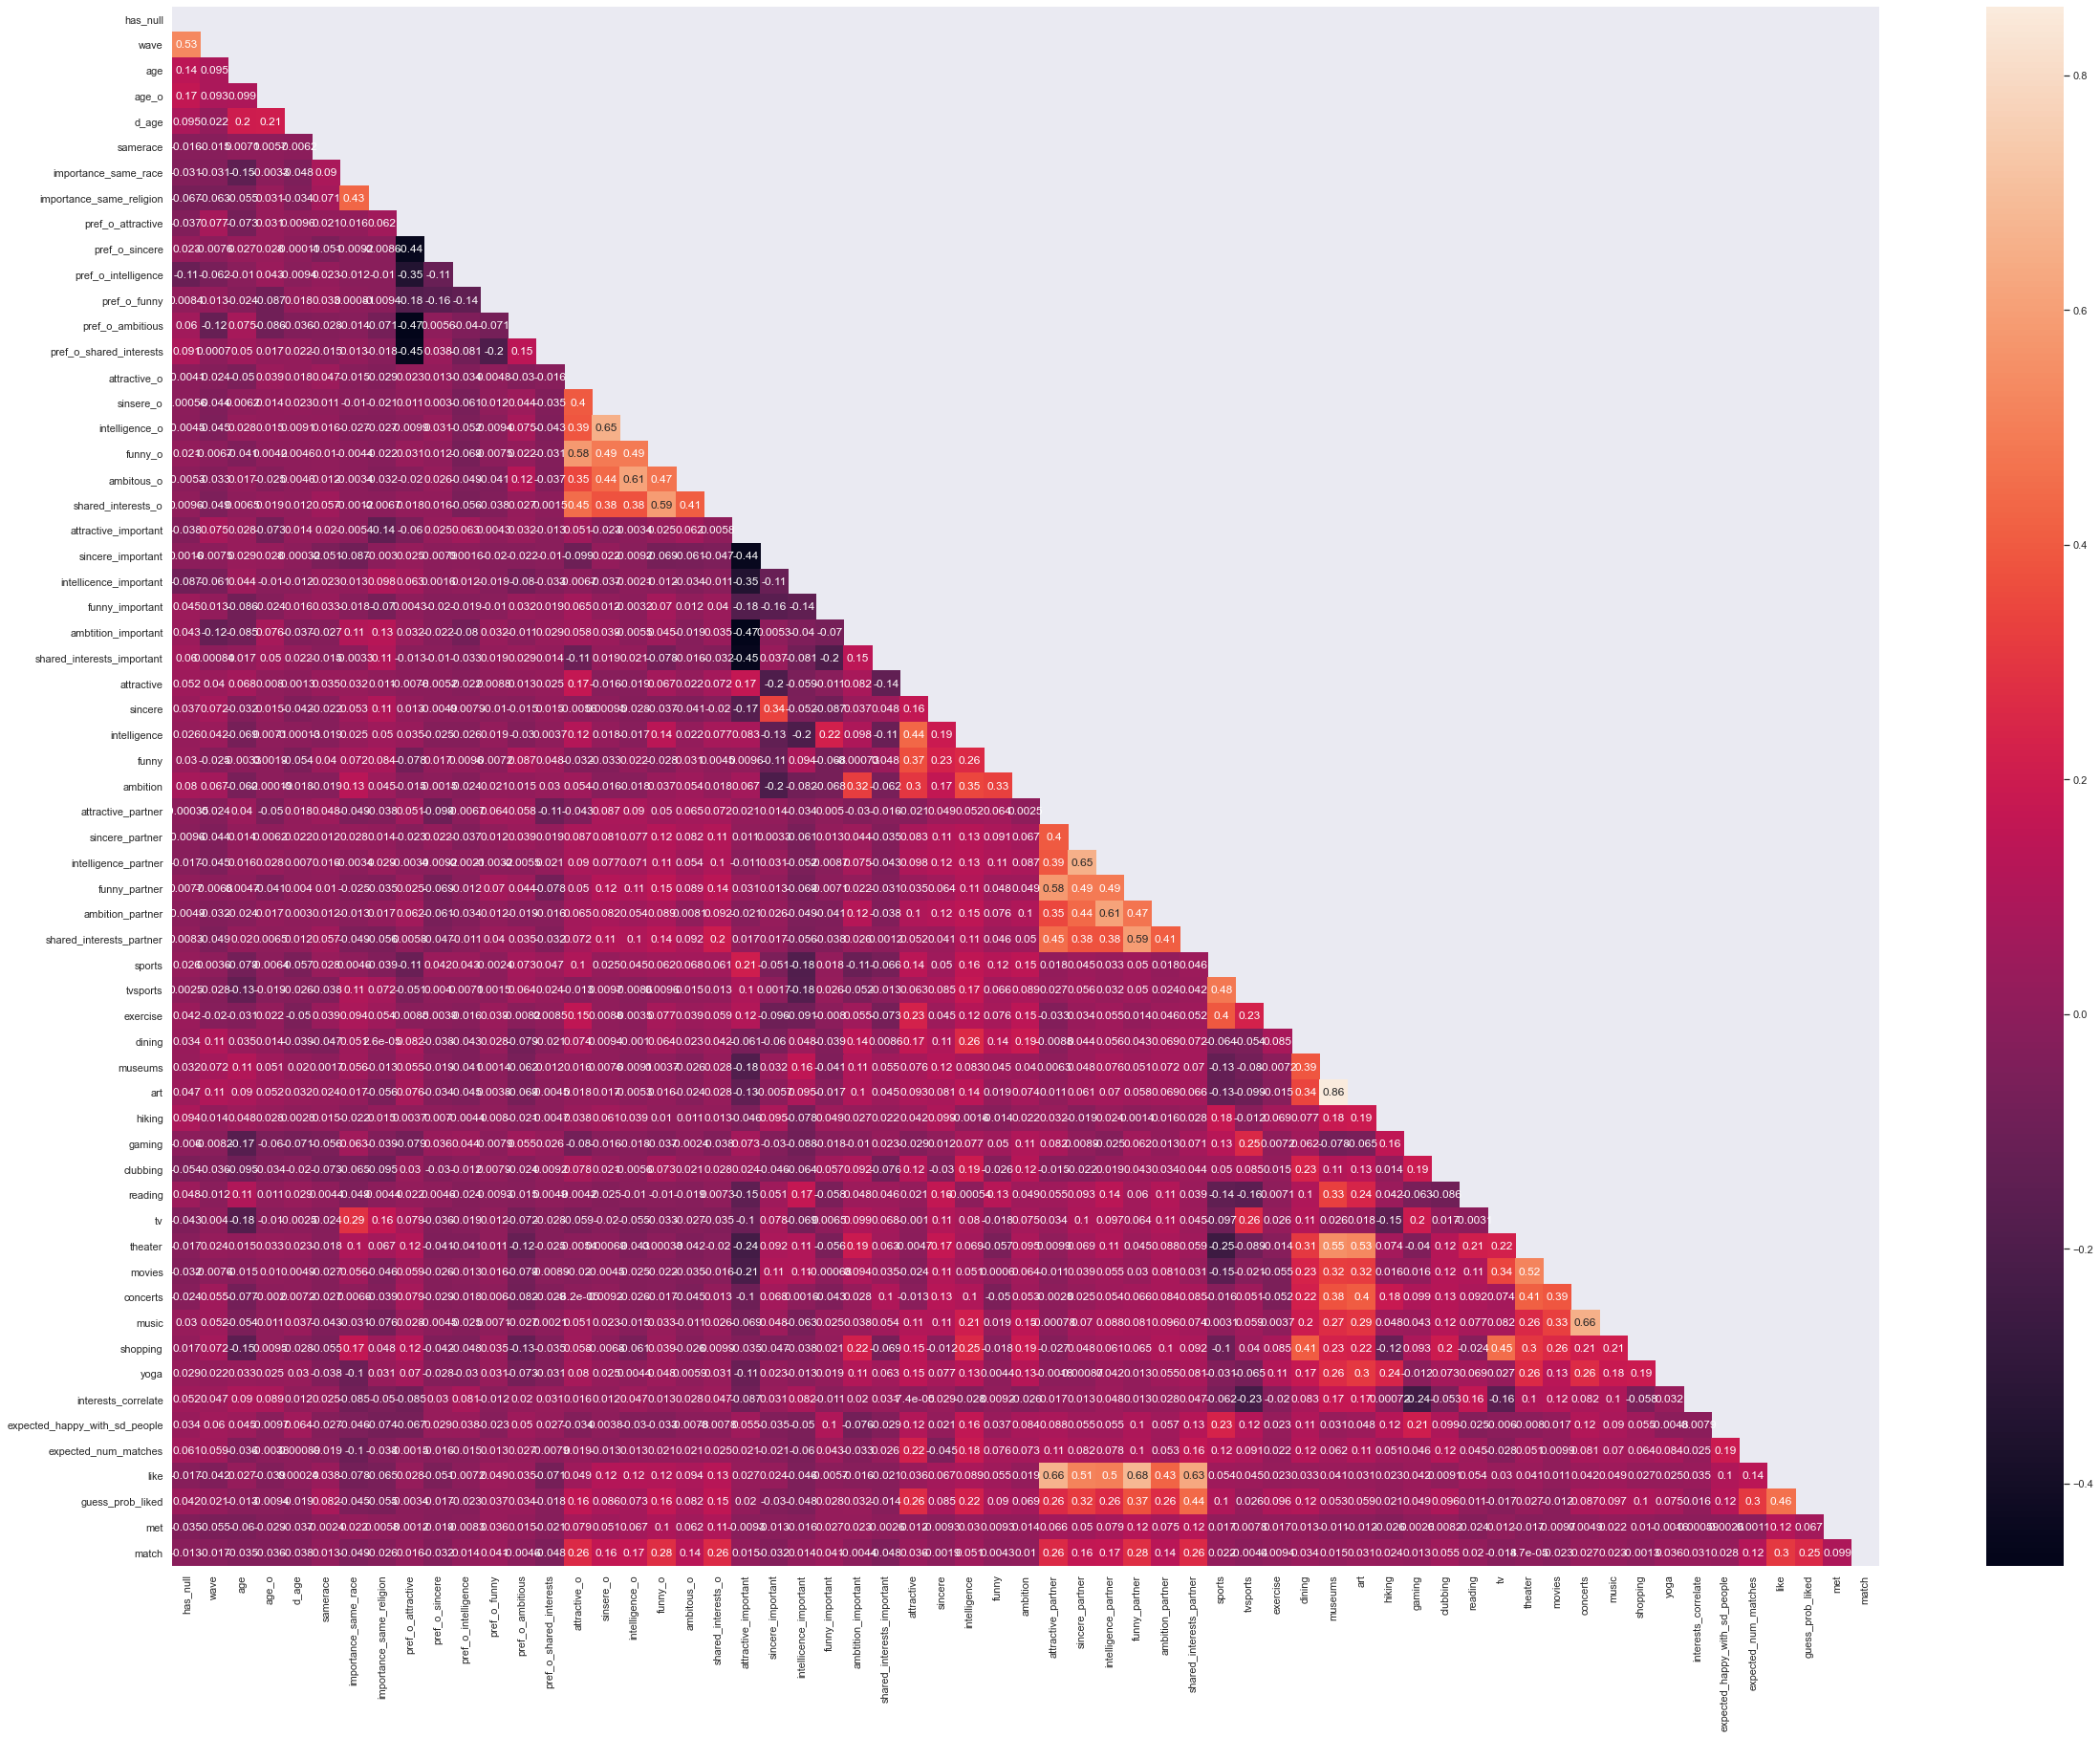

In [152]:
sns.set(rc = {'figure.figsize':(40,30)})
sns.heatmap(corr_matrix, annot=True)
plt.show()

**While there aren't any features that direcly correlate strongly with `match`, we can see that there are a few strongly correlated features (such as `museums` and `art`) and there are some interesting clusters, such as the features that correlate with `like` and the ratings of each person according to their date.**

### Validation & one-hot encoding

In [153]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

#df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

#y_full_train = df_full_train.values
y_train = df_train.match.values
y_val = df_val.match.values
y_test = df_test.match.values

#del df_full_train['match']
del df_train['match']
del df_val['match']
del df_test['match']

In [155]:
df_train.head()

,has_null,wave,gender,age,age_o,d_age,race,race_o,samerace,importance_same_race,...,concerts,music,shopping,yoga,interests_correlate,expected_happy_with_sd_people,expected_num_matches,like,guess_prob_liked,met
0,1,7,male,23.0,24.000000,1,european/caucasian-american,european/caucasian-american,1,3.0,...,4.0,9.0,5.0,1.0,0.42000,7.0,4.000000,9.0,6.0,0.0
1,1,7,male,22.0,28.000000,6,european/caucasian-american,asian/pacific_islander/asian-american,0,6.0,...,6.0,9.0,6.0,2.0,0.20000,7.0,3.207814,5.0,3.0,0.0
2,1,3,male,27.0,26.364999,27,black/african_american,Unknown,0,1.0,...,7.0,7.0,7.0,1.0,0.19601,5.0,3.207814,7.0,0.0,0.0
3,1,14,female,33.0,30.000000,3,latino/hispanic_american,european/caucasian-american,0,2.0,...,1.0,4.0,10.0,4.0,0.03000,2.0,6.000000,5.0,4.0,0.0
4,0,4,female,23.0,27.000000,4,asian/pacific_islander/asian-american,asian/pacific_islander/asian-american,1,4.0,...,7.0,6.0,4.0,1.0,0.74000,5.0,2.000000,5.0,4.0,0.0


#### DictVectorizer

<img src='this.jpg'>

<img src='this22.jpg'>

In [158]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')
test_dict = df_test.to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)
X_test = dv.transform(test_dict)


In [161]:
train_dict

[{'has_null': 1,
  'wave': 7,
  'gender': 'male',
  'age': 23.0,
  'age_o': 24.0,
  'd_age': 1,
  'race': 'european/caucasian-american',
  'race_o': 'european/caucasian-american',
  'samerace': 1,
  'importance_same_race': 3.0,
  'importance_same_religion': 4.0,
  'field': 'physics_(astrophysics)',
  'pref_o_attractive': 11.36,
  'pref_o_sincere': 18.18,
  'pref_o_intelligence': 22.73,
  'pref_o_funny': 18.18,
  'pref_o_ambitious': 11.36,
  'pref_o_shared_interests': 18.18,
  'attractive_o': 7.0,
  'sinsere_o': 10.0,
  'intelligence_o': 10.0,
  'funny_o': 7.0,
  'ambitous_o': 9.0,
  'shared_interests_o': 8.0,
  'attractive_important': 19.05,
  'sincere_important': 19.05,
  'intellicence_important': 19.05,
  'funny_important': 19.05,
  'ambtition_important': 9.52,
  'shared_interests_important': 14.29,
  'attractive': 7.0,
  'sincere': 9.0,
  'intelligence': 7.0,
  'funny': 9.0,
  'ambition': 6.0,
  'attractive_partner': 9.0,
  'sincere_partner': 8.0,
  'intelligence_partner': 9.0,
  'f

In [160]:
X_train

array([[23.        , 24.        ,  6.        , ...,  4.        ,
         7.        ,  1.        ],
       [22.        , 28.        ,  7.        , ...,  9.        ,
         7.        ,  2.        ],
       [27.        , 26.36499879,  8.        , ...,  2.        ,
         3.        ,  1.        ],
       ...,
       [30.        , 25.        ,  9.        , ...,  2.        ,
        16.        ,  4.        ],
       [26.        , 24.        ,  7.        , ...,  5.        ,
         8.        ,  1.        ],
       [27.        , 32.        ,  7.        , ...,  2.        ,
        11.        ,  5.        ]])

### Decision Tree Model
**Basic DT model**


In [173]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [174]:
y_pred = dt.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6250973177624913

**That is because DT likes to overfit**

In [175]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- like <= 6.32
|   |--- funny_o <= 6.70
|   |   |--- movies <= 1.00
|   |   |   |--- class: 1
|   |   |--- movies >  1.00
|   |   |   |--- shared_interests_partner <= 8.50
|   |   |   |   |--- field=money <= 0.50
|   |   |   |   |   |--- intelligence_o <= 7.75
|   |   |   |   |   |   |--- field=neuroscience_and_education <= 0.50
|   |   |   |   |   |   |   |--- field=sipa_energy <= 0.50
|   |   |   |   |   |   |   |   |--- field=business_and_international_affairs_(mba/mia_dual_degree) <= 0.50
|   |   |   |   |   |   |   |   |   |--- field=health_policy <= 0.50
|   |   |   |   |   |   |   |   |   |   |--- attractive_o <= 9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 9
|   |   |   |   |   |   |   |   |   |   |--- attractive_o >  9.50
|   |   |   |   |   |   |   |   |   |   |   |--- truncated branch of depth 2
|   |   |   |   |   |   |   |   |   |--- field=health_policy >  0.50
|   |   |   |   |   |   |   |   |   |   |--- pref_o_shared_interests <= 12.

In [176]:
importance_df = pd.DataFrame({
    'feature': dv.get_feature_names(),
    'importance': dt.feature_importances_
}).sort_values('importance', ascending=False)

In [177]:
importance_df.head(10)

,feature,importance
240,like,0.100549
9,attractive_o,0.082371
10,attractive_partner,0.043227
239,interests_correlate,0.037078
225,funny_o,0.030598
266,shared_interests_o,0.030412
17,expected_num_matches,0.028107
230,guess_prob_liked,0.025359
248,pref_o_intelligence,0.022728
250,pref_o_sincere,0.019710


<AxesSubplot:title={'center':'Feature Importance'}, xlabel='importance', ylabel='feature'>

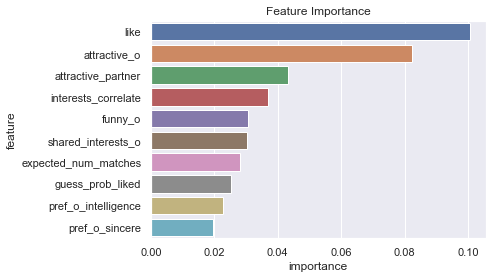

In [181]:
plt.title('Feature Importance')
sns.barplot(data=importance_df.head(10), x='importance', y='feature')

In [182]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [183]:
y_pred = dt.predict_proba(X_train)[:, 1]
auc = roc_auc_score(y_train, y_pred)
print('train:', auc)

y_pred = dt.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print('val:', auc)

train: 0.7714200395877415
val: 0.7622447075134645


In [184]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- like <= 6.32
|   |--- funny_o <= 6.70
|   |   |--- class: 0
|   |--- funny_o >  6.70
|   |   |--- class: 0
|--- like >  6.32
|   |--- attractive_o <= 6.75
|   |   |--- class: 0
|   |--- attractive_o >  6.75
|   |   |--- class: 0



**We can see that a simple tree of max depth 2 has a better AUC score than a tree with unlimited depth. Let's finetune it.**

**We will finetune the `max_depth` and the `min_samples_leaf` hyperparameters.**

In [185]:
scores = []

for depth in tqdm([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 15, 20, 30, 40, 60, None]):
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)[:, 1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((depth, s, auc))

100%|██████████| 17/17 [00:18<00:00,  1.07s/it]


In [188]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                                                   \
max_depth           NaN   1.0    2.0    3.0    4.0    5.0    6.0    7.0    
min_samples_leaf                                                           
1                 0.632  0.676  0.762  0.800  0.796  0.797  0.781  0.770   
5                 0.656  0.676  0.762  0.800  0.795  0.792  0.770  0.760   
10                0.716  0.676  0.762  0.802  0.796  0.788  0.776  0.750   
15                0.750  0.676  0.762  0.802  0.799  0.786  0.773  0.765   
20                0.752  0.676  0.762  0.799  0.795  0.786  0.767  0.757   
100               0.799  0.676  0.762  0.799  0.806  0.791  0.799  0.799   
200               0.809  0.676  0.762  0.805  0.811  0.810  0.809  0.809   
500               0.799  0.676  0.762  0.799  0.799  0.799  0.799  0.799   

                                                                          \
max_depth          8.0    9.0    10.0   12.0   15.0   20.0   30.0   40.0   
min_samples_leaf                                                           
1                 0.748  0.708  0.649  0.572  0.567  0.605  0.631  0.628   
5                 0.726  0.698  0.657  0.628  0.655  0.651  0.646  0.663   
10                0.727  0.691  0.688  0.683  0.707  0.708  0.719  0.715   
15                0.763  0.754  0.750  0.752  0.752  0.755  0.754  0.758   
20                0.747  0.744  0.729  0.750  0.741  0.748  0.740  0.742   
100               0.800  0.799  0.799  0.800  0.799  0.799  0.799  0.799   
200               0.809  0.809  0.809  0.809  0.809  0.809  0.809  0.809   
500               0.799  0.799  0.799  0.799  0.799  0.799  0.799  0.799   

                         
max_depth          60.0  
min_samples_leaf         
1                 0.620  
5                 0.649  
10                0.708  
15                0.753  
20                0.748  
100               0.800  
200               0.809  
500               0.799

<AxesSubplot:xlabel='None-max_depth', ylabel='min_samples_leaf'>

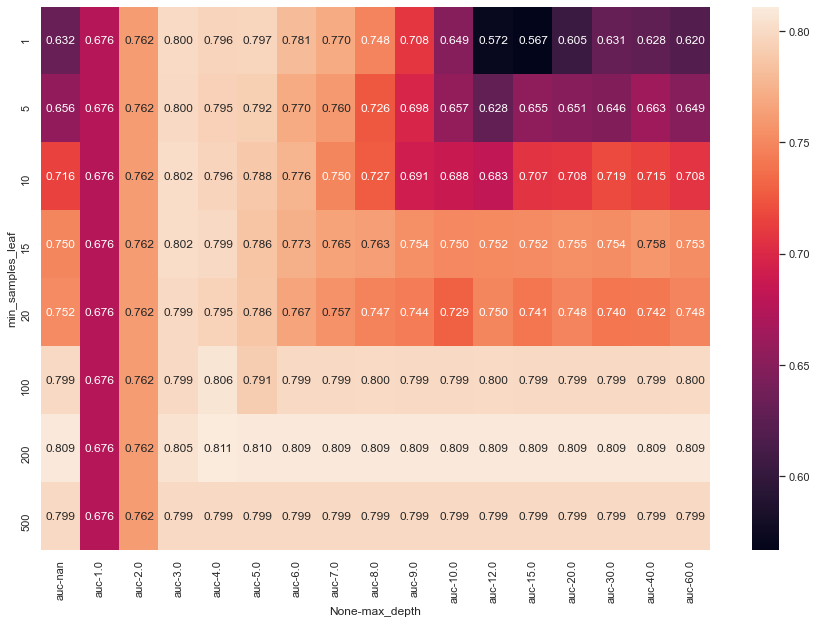

In [187]:
sns.set(rc = {'figure.figsize':(15,10)})
sns.heatmap(df_scores_pivot, annot=True, fmt=".3f")

It seems that the best score was achieved with a `max_depth` of `4` and a `min_samples_leaf` of `200`.

As a conclusion, we've managed to obtain an `AUC` score of `0.811` with a Decision Tree Classifier model.



In [194]:
dt = DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)
dt.fit(X_train, y_train)
y_pred = dt.predict_proba(X_val)[:, 1]
print('Decission Tree Classifier model')
print(f'ROC AUC score: {roc_auc_score(y_val, y_pred)}')

Decission Tree Classifier model
ROC AUC score: 0.8110155708419987


In [195]:
def max_depth_error(md):
    model = DecisionTreeClassifier(max_depth=md, random_state=42)
    model.fit(X_train, y_train)
    train_acc = 1 - model.score(X_train, y_train)
    val_acc = 1 - model.score(X_val, y_val)
    return {'Max Depth': md, 'Training Error': train_acc, 'Validation Error': val_acc}

In [196]:
errors_df = pd.DataFrame([max_depth_error(md) for md in range(1, 21)])

In [197]:
errors_df

,Max Depth,Training Error,Validation Error
0,1,0.167131,0.158711
1,2,0.167131,0.158711
2,3,0.154397,0.146778
3,4,0.147234,0.149761
4,5,0.135495,0.155131
5,6,0.128134,0.153938
6,7,0.113609,0.158115
7,8,0.098289,0.174224
8,9,0.077596,0.170048
9,10,0.058496,0.187947


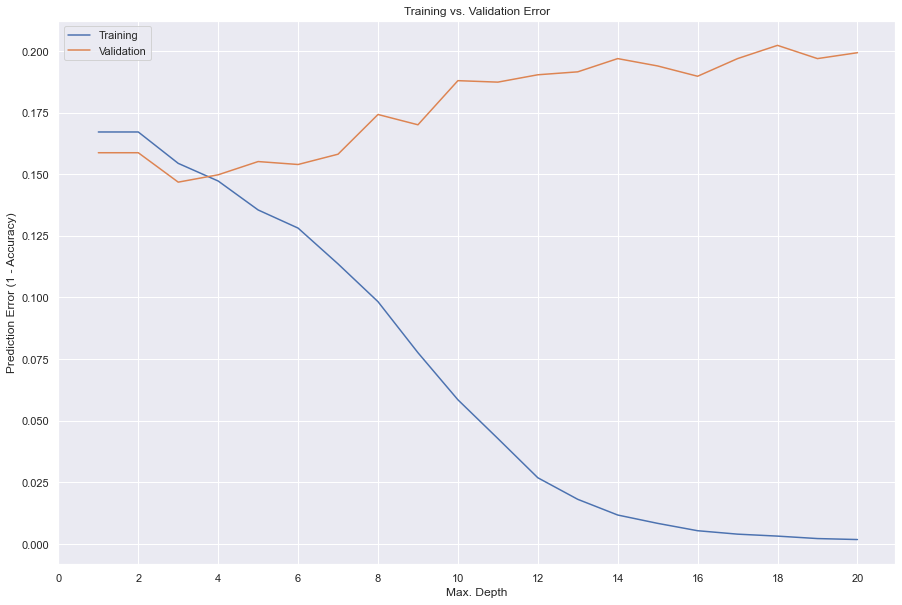

In [198]:
plt.figure()
plt.plot(errors_df['Max Depth'], errors_df['Training Error'])
plt.plot(errors_df['Max Depth'], errors_df['Validation Error'])
plt.title('Training vs. Validation Error')
plt.xticks(range(0,21, 2))
plt.xlabel('Max. Depth')
plt.ylabel('Prediction Error (1 - Accuracy)')
plt.legend(['Training', 'Validation'])

And again it's in `max_depth = 4`

### Decision Tree model cross-validation

In [199]:
def train_dt(df_train_k, y_train_k):
    dict_k = df_train_k.to_dict(orient='records')

    dv_k = DictVectorizer(sparse=False)
    X_train_k = dv_k.fit_transform(dict_k)

    model_k = DecisionTreeClassifier(max_depth=4, min_samples_leaf=200)
    model_k.fit(X_train_k, y_train_k)
    
    return dv_k, model_k

def predict_dt(df_k, dv_k, model_k):
    dict_k = df_k.to_dict(orient='records')

    X_k = dv_k.transform(dict_k)
    y_pred_k = model_k.predict_proba(X_k)[:, 1]

    return y_pred_k

In [200]:
n_splits = 5

scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_k = df_full_train.iloc[train_idx]
    df_val_k = df_full_train.iloc[val_idx]

    y_train_k = df_train_k.match.values
    y_val_k = df_val_k.match.values

    del df_train_k['match']
    del df_val_k['match']

    dv_k, model_k = train_dt(df_train_k, y_train_k)
    y_pred_k = predict_dt(df_val_k, dv_k, model_k)

    auc = roc_auc_score(y_val_k, y_pred_k)
    scores.append(auc)


In [202]:
print(scores)
print(f'Scores mean: {np.mean(scores)}')

[0.8193286456335035, 0.8174978646476876, 0.8101780960169831, 0.806525974025974, 0.8247272317039759]
Scores mean: 0.8156515624056249


### Random Forest Model

In [203]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8432797419079614

### Random Forest Model Finetuning
increase `n_estimators`

In [230]:
scores = []
best_n_estimators_model = None 
sum_score=[]
for n in range(10, 300, 10):
    rf = RandomForestClassifier(n_estimators=n, random_state=42, n_jobs=-1)
    rf.fit(X_train, y_train)

    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    sum_score += [auc]

    scores.append((n, auc))

    if auc >= np.max(sum_score):
        best_cluster_model = rf

In [232]:
best_cluster_model.n_estimators

220

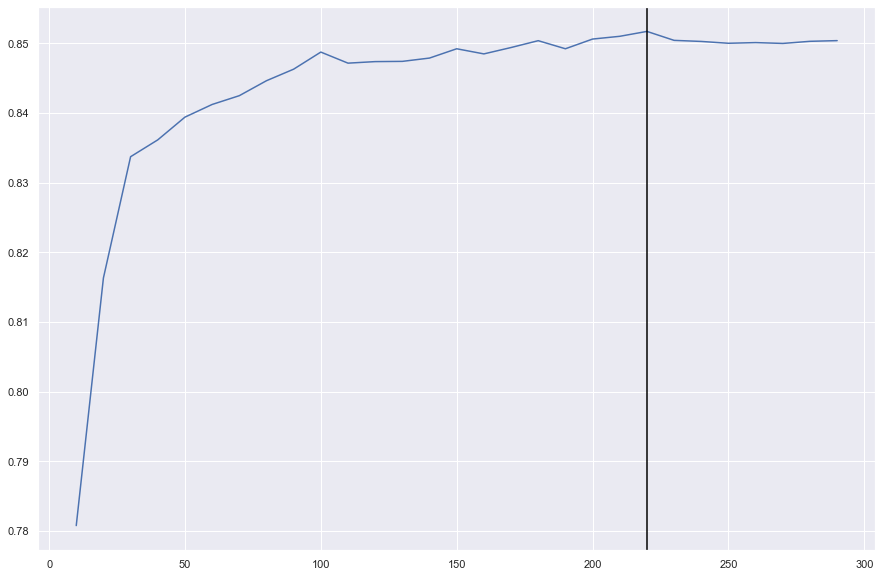

In [231]:
df_scores = pd.DataFrame(scores, columns=['n_estimators', 'auc'])
plt.plot(df_scores.n_estimators, df_scores.auc)
plt.axvline(best_cluster_model.n_estimators, color='black')

In [233]:
df_scores[df_scores.auc == df_scores.auc.max()]

,n_estimators,auc
21,220,0.851684


Our best amount of `n_estimators` is `220`. Let's train a single model with that amount of estimators and check the depths

In [234]:
rf = RandomForestClassifier(n_estimators=220, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.8516837306031035

Check now for `max_depth`

In [241]:
scores = []

for d in tqdm(range(1, 20, 1)):
    for n in range(10, 300, 10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=42, n_jobs=-1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d, n, auc))

100%|██████████| 19/19 [10:05<00:00, 31.84s/it]


In [244]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores[df_scores.auc == df_scores.auc.max()]

,max_depth,n_estimators,auc
404,14,280,0.853573


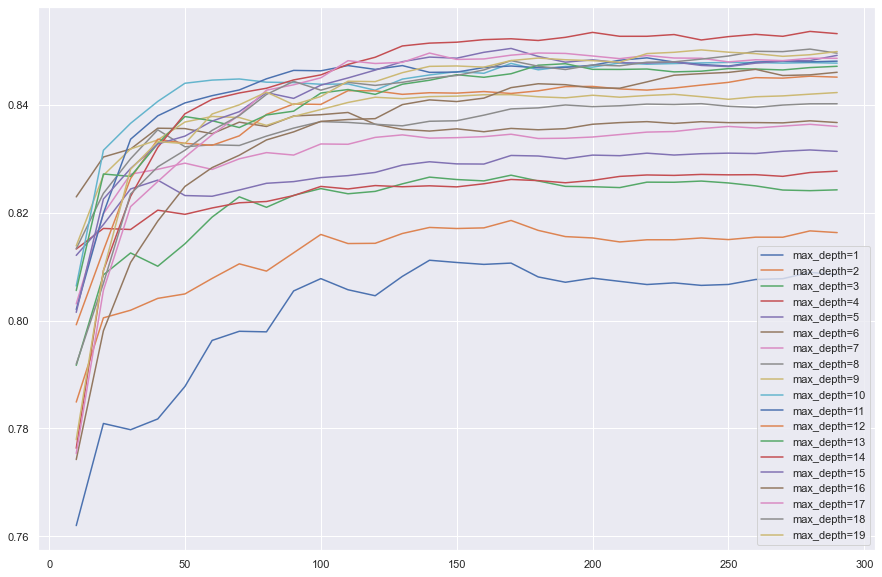

In [243]:
for d in range(1, 20, 1):
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%d' % d)

plt.legend()

In [253]:
rf = RandomForestClassifier(n_estimators=280, max_depth=14, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
print('Random Forest Classifier model')
print(f'ROC AUC score: {roc_auc_score(y_val, y_pred)}')


Random Forest Classifier model
ROC AUC score: 0.8535727616914628


### Random Forest cross-validation

In [254]:
def train_rf(df_train_k, y_train_k):
    dict_k = df_train_k.to_dict(orient='records')

    dv_k = DictVectorizer(sparse=False)
    X_train_k = dv_k.fit_transform(dict_k)

    model_k = RandomForestClassifier(n_estimators=280, max_depth=14, random_state=42, n_jobs=-1)
    model_k.fit(X_train_k, y_train_k)
    
    return dv_k, model_k

def predict_rf(df_k, dv_k, model_k):
    dict_k = df_k.to_dict(orient='records')

    X_k = dv_k.transform(dict_k)
    y_pred_k = model_k.predict_proba(X_k)[:, 1]

    return y_pred_k

In [255]:
n_splits = 5

scores = []

kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)

for train_idx, val_idx in kfold.split(df_full_train):
    df_train_k = df_full_train.iloc[train_idx]
    df_val_k = df_full_train.iloc[val_idx]

    y_train_k = df_train_k.match.values
    y_val_k = df_val_k.match.values

    del df_train_k['match']
    del df_val_k['match']

    dv_k, model_k = train_rf(df_train_k, y_train_k)
    y_pred_k = predict_rf(df_val_k, dv_k, model_k)

    auc = roc_auc_score(y_val_k, y_pred_k)
    scores.append(auc)


In [257]:
print(scores)
print(f'Scores mean: {np.mean(scores)}')

[0.8548534663400524, 0.8704691140983009, 0.84502949416207, 0.8533157467532466, 0.8630235781398572]
Scores mean: 0.8573382798987055
